Dataset path: C:\Users\aroma\.cache\kagglehub\datasets\gauravduttakiit\resume-dataset\versions\1
Files in dataset path: ['UpdatedResumeDataSet.csv']
CSV found at: C:\Users\aroma\.cache\kagglehub\datasets\gauravduttakiit\resume-dataset\versions\1\UpdatedResumeDataSet.csv
Dataset loaded successfully
Shape: (962, 2)
Columns: Index(['Category', 'Resume'], dtype='object')
       Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills Ã¢ÂÂ¢ R Ã¢ÂÂ¢ Python Ã¢ÂÂ¢ SAP HANA ...
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...

Classification Report:

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
 

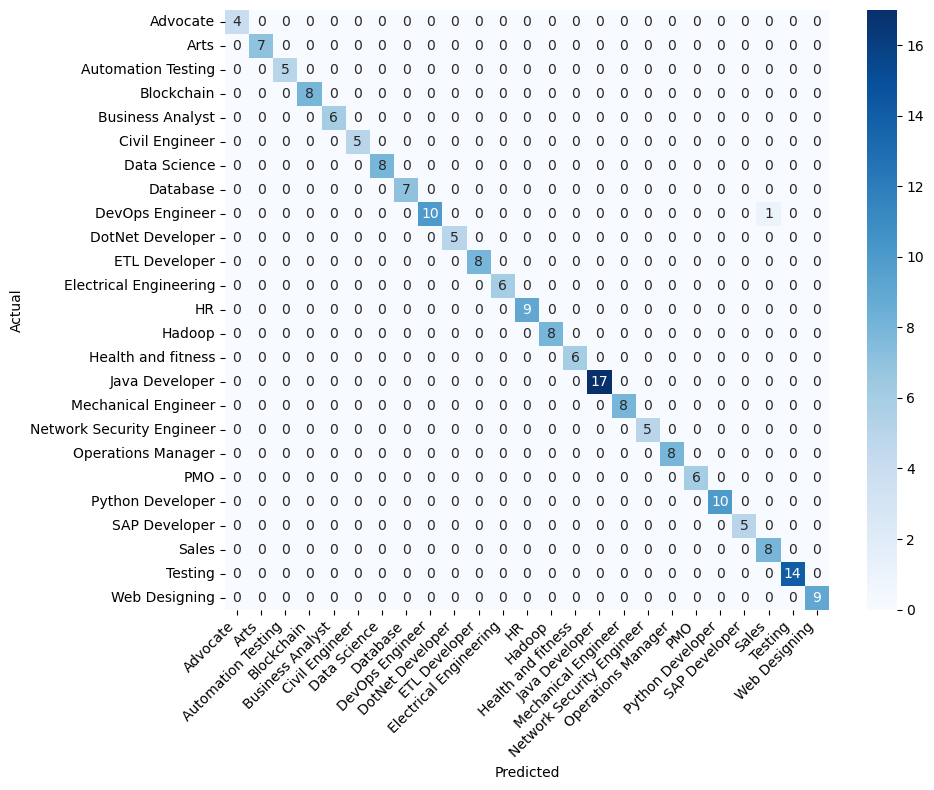


Top 20 Features:

                     feature  importance
2272                    java    0.012967
236                     arts    0.010459
2000                      hr    0.009900
2274          java developer    0.009422
1254               developer    0.009020
4537        testing engineer    0.008953
2695              mechanical    0.008442
2001                hr skill    0.007777
3514        python developer    0.007604
2698  mechanical engineering    0.007574
3513                  python    0.007405
1474                engineer    0.007259
1260          developer java    0.006945
4130                   smart    0.006752
413               blockchain    0.006741
4531                 testing    0.006657
3853                   sales    0.006447
1438              electrical    0.006411
3857           sales manager    0.006165
2320                     jsp    0.006036


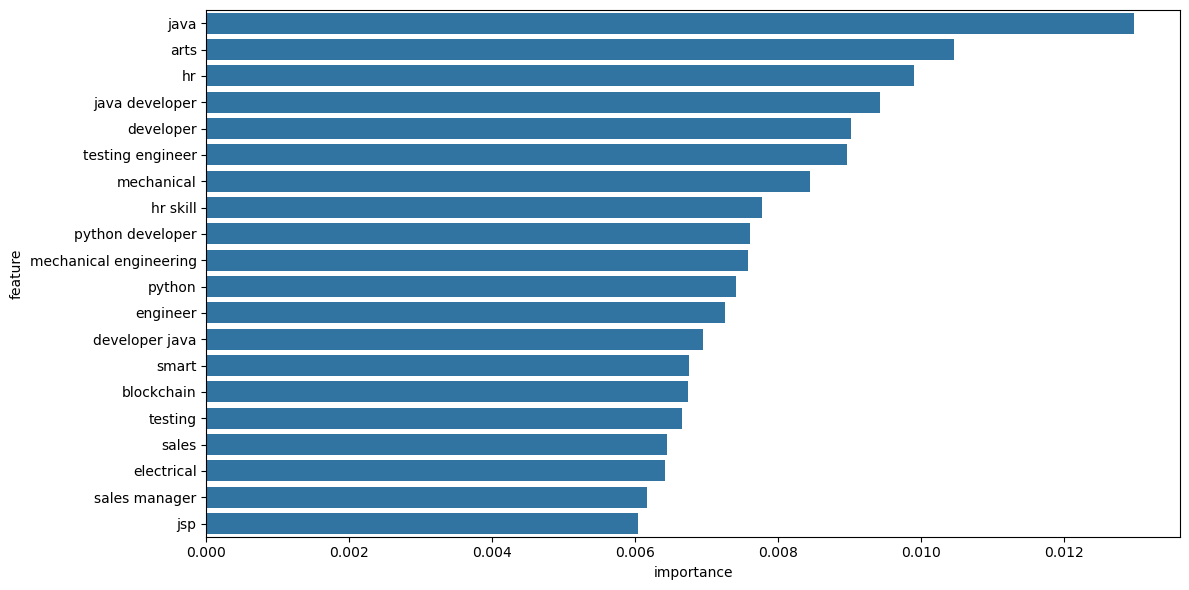

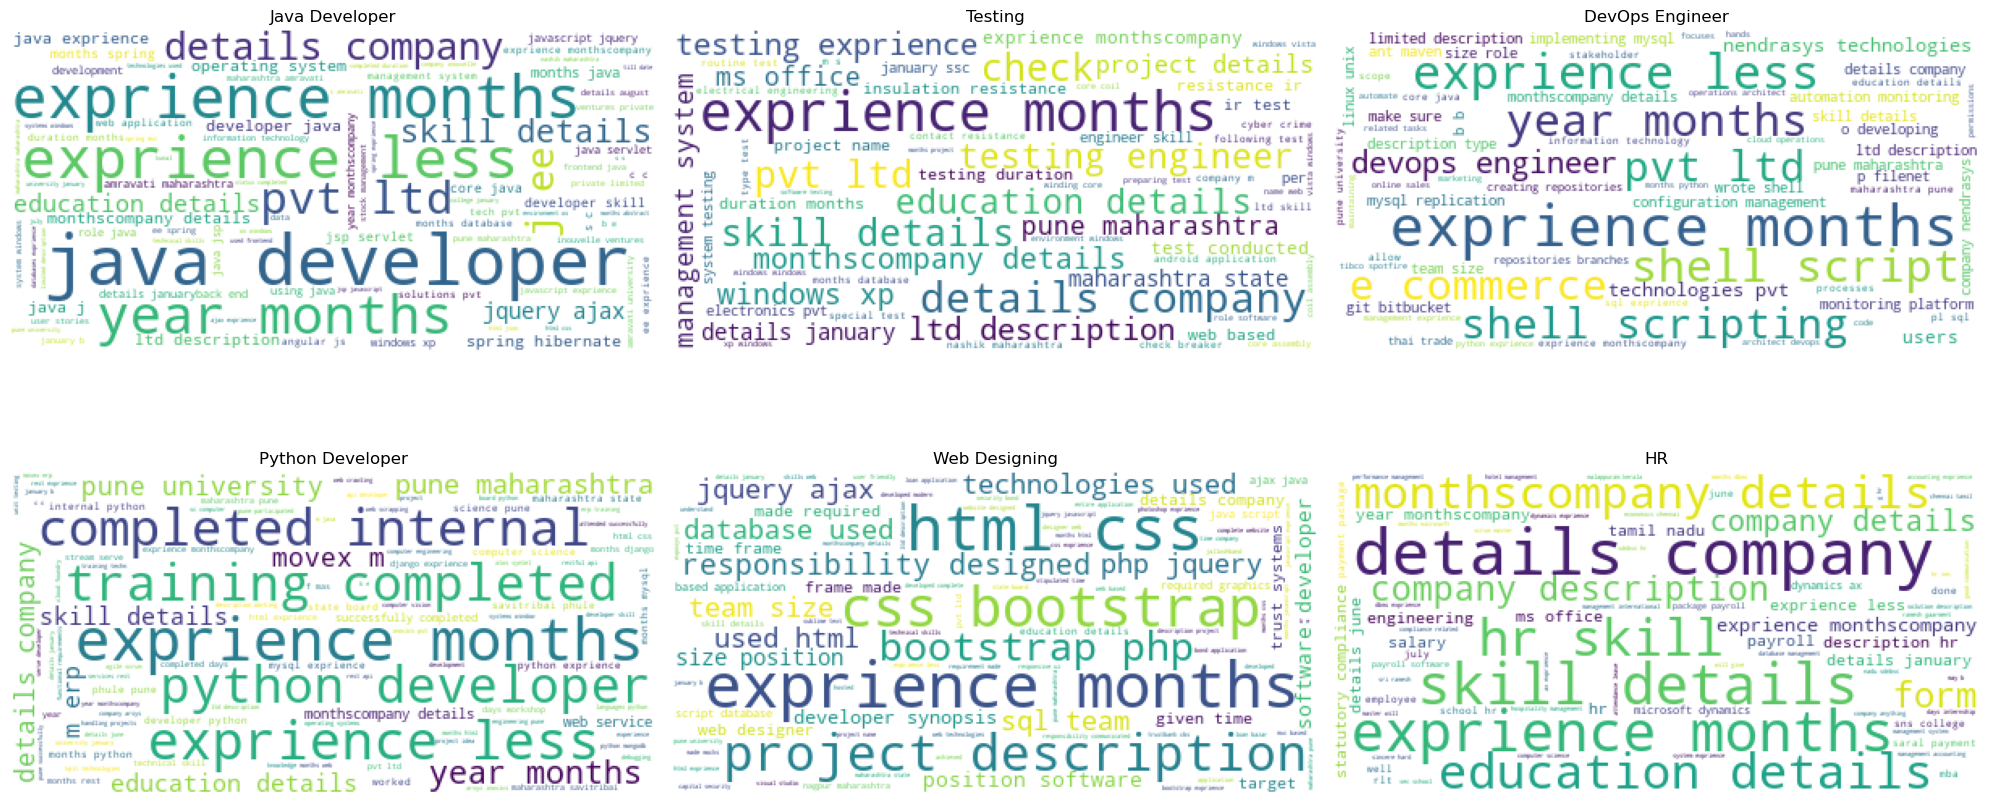

Models saved


,Category,similarity_score
38,Data Science,0.229683
18,Data Science,0.229683
28,Data Science,0.229683
8,Data Science,0.229683
7,Data Science,0.194993


In [ ]:
# ================================
# Resume Classification & Job Matching Pipeline
# FINAL FINAL – handles BOTH zip & non-zip Kaggle downloads
# USING RANDOM FOREST CLASSIFIER AND TF-IDF VECTORIZATION
# ================================

# -------- Imports --------
import os
import zipfile
import re
import joblib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud

import kagglehub

# ================================
# Step 1: Download dataset from Kaggle
# ================================

DATASET = "gauravduttakiit/resume-dataset"

# kagglehub downloads and EXTRACTS automatically in newer versions
# It returns a directory path

dataset_path = kagglehub.dataset_download(DATASET)
print("Dataset path:", dataset_path)
print("Files in dataset path:", os.listdir(dataset_path))

# ================================
# Step 2: Locate CSV safely (zip OR direct CSV)
# ================================

CSV_NAME = "UpdatedResumeDataSet.csv"
CSV_PATH = None

# Case 1: CSV exists directly
if CSV_NAME in os.listdir(dataset_path):
    CSV_PATH = os.path.join(dataset_path, CSV_NAME)

# Case 2: CSV inside zip (older kagglehub versions)
else:
    zip_files = [f for f in os.listdir(dataset_path) if f.endswith('.zip')]

    if len(zip_files) > 0:
        zip_path = os.path.join(dataset_path, zip_files[0])
        extract_dir = os.path.join(dataset_path, "extracted")
        os.makedirs(extract_dir, exist_ok=True)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        CSV_PATH = os.path.join(extract_dir, CSV_NAME)

# Final safety check
if CSV_PATH is None or not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"{CSV_NAME} not found in Kaggle dataset")

print("CSV found at:", CSV_PATH)

# ================================
# Step 3: Load CSV correctly (text-safe)
# ================================

resume_df = pd.read_csv(
    CSV_PATH,
    encoding="latin-1",
    engine="python",
    on_bad_lines="skip"
)

# Clean column names (CRITICAL)
resume_df.columns = (
    resume_df.columns
    .str.strip()
    .str.replace('\ufeff', '', regex=False)
)

print("Dataset loaded successfully")
print("Shape:", resume_df.shape)
print("Columns:", resume_df.columns)
print(resume_df.head())

# Ensure required columns exist
assert 'Resume' in resume_df.columns
assert 'Category' in resume_df.columns

# ================================
# Text Preprocessing
# ================================

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

resume_df['processed_text'] = resume_df['Resume'].apply(preprocess_text)

# ================================
# Encode Labels
# ================================

label_encoder = LabelEncoder()
resume_df['encoded_category'] = label_encoder.fit_transform(resume_df['Category'])

# ================================
# TF-IDF Vectorization
# ================================

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

tfidf_features = tfidf_vectorizer.fit_transform(resume_df['processed_text'])

X = tfidf_features
y = resume_df['encoded_category']

# ================================
# Train-Test Split
# ================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ================================
# Model Training
# ================================

rf_classifier = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_classifier.fit(X_train, y_train)

# ================================
# Evaluation
# ================================

y_pred = rf_classifier.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# ================================
# Confusion Matrix
# ================================

cm = confusion_matrix(y_test, y_pred)
classes = label_encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ================================
# Feature Importance
# ================================

feature_importance = pd.DataFrame({
    'feature': tfidf_vectorizer.get_feature_names_out(),
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Features:\n")
print(feature_importance.head(20))

plt.figure(figsize=(12, 6))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance.head(20)
)
plt.tight_layout()
plt.show()

# ================================
# Word Clouds
# ================================

top_categories = resume_df['Category'].value_counts().head(6).index
plt.figure(figsize=(20, 10))

for i, cat in enumerate(top_categories):
    text = ' '.join(resume_df[resume_df['Category'] == cat]['processed_text'])
    wc = WordCloud(background_color='white').generate(text)

    plt.subplot(2, 3, i + 1)
    plt.imshow(wc)
    plt.title(cat)
    plt.axis('off')

plt.tight_layout()
plt.show()

# ================================
# Save Artifacts
# ================================

joblib.dump(rf_classifier, 'resume_classifier_model.pkl')
joblib.dump(tfidf_vectorizer, 'resume_tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'resume_label_encoder.pkl')

print("Models saved")

# ================================
# Resume ↔ Job Matching
# ================================

def match_job_with_resumes(job_description, top_n=5):
    processed_job = preprocess_text(job_description)
    job_vec = tfidf_vectorizer.transform([processed_job])
    scores = cosine_similarity(job_vec, tfidf_features).flatten()

    top_idx = scores.argsort()[::-1][:top_n]
    results = resume_df.iloc[top_idx][['Category']].copy()
    results['similarity_score'] = scores[top_idx]

    return results

def predict_resume_category(new_resume_text):
    processed = preprocess_text(new_resume_text)

    # Vectorize (IMPORTANT: transform, not fit)
    vectorized = tfidf_vectorizer.transform([processed])

    # Predict encoded label
    pred_encoded = rf_classifier.predict(vectorized)

    # Decode label
    pred_label = label_encoder.inverse_transform(pred_encoded)

    # Confidence (optional)
    confidence = rf_classifier.predict_proba(vectorized).max()

    return pred_label[0], confidence


# Example:
x=match_job_with_resumes("Python ML engineer with NLP experience")

print("------------------------------------------------")
print(x)


In [18]:
x=match_job_with_resumes("Python ML engineer with NLP experience")

print("------------------------------------------------")
print(x.max)


------------------------------------------------
<bound method DataFrame.max of         Category  similarity_score
38  Data Science          0.229683
18  Data Science          0.229683
28  Data Science          0.229683
8   Data Science          0.229683
7   Data Science          0.194993>


In [ ]:
def predict_resume_category(new_resume_text):
    # Preprocess (same as training)
    processed = preprocess_text(new_resume_text)

    # Vectorize (IMPORTANT: transform, not fit)
    vectorized = tfidf_vectorizer.transform([processed])

    # Predict encoded label
    pred_encoded = rf_classifier.predict(vectorized)

    # Decode label
    pred_label = label_encoder.inverse_transform(pred_encoded)

    # Confidence (optional)
    confidence = rf_classifier.predict_proba(vectorized).max()

    return pred_label[0], confidence

new_resume = """ html developer with6 yr experice 
"""

category, confidence = predict_resume_category(new_resume)

print("Predicted Category:", category)
print("Confidence:", round(confidence, 3))


Predicted Category: Advocate
Confidence: 0.235
